# Using the `do-operator` to simulate data

This tutorial illustrates how we can use the underlying `PyMC` model of a given HSSM model, to forward simulate datasets that you may use for numerical studies.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import hssm
import pymc as pm

### Simulate Data

We will simulate a simple dataset that contains two conditions. 

In [2]:
# Simple model
data = hssm.simulate_data(
    model="ddm", theta=dict(v=0.5, a=1.5, z=0.5, t=0.1), size=500
)

### Specify HSSM Model

We will fit two separate models to the data.

In [3]:
# Model 1
hssm_model = hssm.HSSM(model="ddm", data=data)

Model initialized successfully.


### Underlying PyMC model

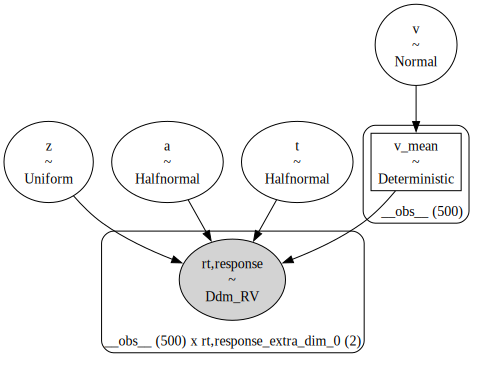

In [4]:
pm.model_to_graphviz(hssm_model.pymc_model)

### Using the `do-operator`

In [5]:
from pymc.model.transform.conditioning import do

synth_idata, synth_model = hssm_model.sample_do(params = {"v": 0,
                                                          "a": 1.5,
                                                          "z": 0.5,
                                                          "t": 0.1},
                                                draws = 100,
                                                return_model = True)

Sampling: [rt,response]


Note that the process defines an new `PyMC` model, which sets the parameters we passed in our `dictionary` to `Data` objects.

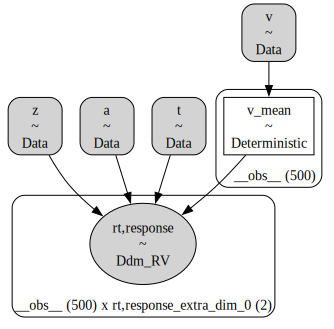

In [6]:
pm.model_to_graphviz(synth_model)

In [7]:
synth_idata

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

Observe two things: 

1. A closer look at the `prior` group reveals that no parameters were actually sampled (it collects on the deterministic `v_mean` which, arguably, we can skip too)
2. The `prior_predictive` group is where we collected our synthetic data

Our synthetic data sits in the `prior_predictive` group, since, under the hood, were de facto called the `sample_prior_predictive()` method, on our new *do-model*.

If you prefer to get your outputs as a dataframe, you can use the `predictive_idata_to_dataframe` method from the `hssm.utils` module.


In [8]:
synth_df = hssm.utils.predictive_idata_to_dataframe(synth_idata,
                                                    predictive_group = "prior_predictive")

In [9]:
synth_df

,chain,draw,__obs__,rt,response
0,0,0,0,1.446554,1.0
1,0,0,1,1.198923,1.0
2,0,0,2,0.892631,-1.0
3,0,0,3,3.382068,1.0
4,0,0,4,0.436959,-1.0
...,...,...,...,...,...
49995,0,99,495,3.510932,1.0
49996,0,99,496,1.799391,1.0
49997,0,99,497,1.187817,-1.0
49998,0,99,498,0.320621,1.0


From here you may re-attach the original data used to define the `hssm_model` (e.g.to re-attach covariates that you want as part of the model you are testing on your synthetic data).

The `sample_do()` function can be extremely helpful in setting up numerical experiments to test e.g. for parameter identifiability in scenarios that you wish to control precisely.